In [1]:
import sympy
sympy.init_printing()

In [2]:
def derive_equations():
    a, b, c = sympy.symbols('a, b, c')
    c_x, c_y, c_z = sympy.symbols('c_x, c_y, c_z')
    x, y, z = sympy.symbols('x, y, z')

    eq = (x - c_x)**2/a + (y - c_y)**2/b + (z - c_z)**2/c
    
    sympy.Poly(eq.expand().simplify(), [x, y, z])
    
    c_vect = sympy.Matrix([ it.simplify() for it in sympy.Poly(eq.expand().simplify(), [x, y, z]).coeffs()])
    c_syms = sympy.Matrix(sympy.symbols('c_0:{:d}'.format(len(c_vect))))
    C = c_vect
    
    rev_coeffs = sympy.solve(list(sympy.Matrix(C) - sympy.Matrix(c_syms)),
        [a, b, c, c_x, c_y, c_z, c_syms[-1]], dict=True)[0]

    def X(n):
        x_vect = sympy.Matrix(sympy.symbols('x_0:{:d}'.format(n)))
        xsq_vect = x_vect.multiply_elementwise(x_vect)

        y_vect = sympy.Matrix(sympy.symbols('y_0:{:d}'.format(n)))
        ysq_vect = y_vect.multiply_elementwise(y_vect)

        z_vect = sympy.Matrix(sympy.symbols('z_0:{:d}'.format(n)))
        zsq_vect = z_vect.multiply_elementwise(z_vect)
        ones = sympy.ones(n, 1)
        X = xsq_vect.row_join(x_vect).row_join(ysq_vect).row_join(
            y_vect).row_join(zsq_vect).row_join(z_vect).row_join(ones)
        return sympy.Matrix(X)

    def Y(n):
        return sympy.ones(n, 1)

    def XTY(n):
        return X(n).T*Y(n)
    
    def XTX(n):
        return X(n).T*X(n)

    def dXTY(n):
        return X(n).T*Y(n) - X(n-1).T*Y(n-1)

    def dXTX(n):
        return X(n).T*X(n) - X(n-1).T*X(n-1)
    
    dXTY2 = dXTY(2)
    dXTX2 = dXTX(2)

    f_dXTX = sympy.lambdify(sympy.symbols('x_1, y_1, z_1'), dXTX(2))
    f_dXTY = sympy.lambdify(sympy.symbols('x_1, y_1, z_1'), dXTY(2))
    
    return locals()

We can solve this using recursive least squares.

$ Y = X C $

$ X^T Y = X^T X C $

$ C = (X^T X)^{-1} X^T Y $

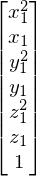

In [3]:
eqs = derive_equations()
eqs['dXTY2']

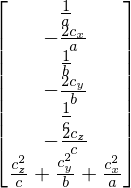

In [4]:
eqs['c_vect']

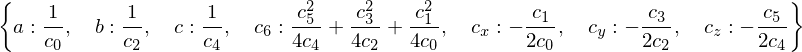

In [5]:
eqs['rev_coeffs']

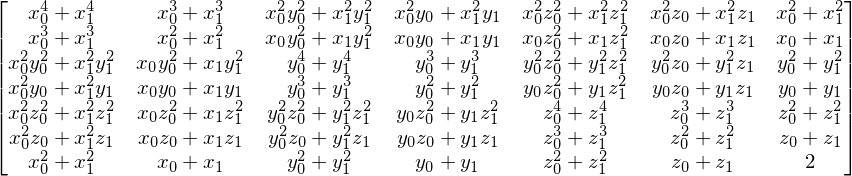

In [6]:
eqs['XTX'](2)

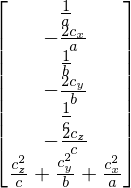

In [7]:
eqs['C']

In [8]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D

def test(eqs):

    data = []
    seed(1234)
    for i in range(1000):
        psi = 2*pi*rand()
        theta = pi*rand()
        data += [[sin(theta)*cos(psi), sin(theta)*np.sin(psi), np.cos(theta)]]
    
    #data = array(data)
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot3D(*data.T, '.')
    
    dxtx_val = np.zeros((7, 7))
    dxty_val = np.zeros((7, 1))

    for i in range(len(data)):
        p = data[i]
        dxtx_val += eqs['f_dXTX'](p[0], p[1], p[2])
        dxty_val += 0.1*eqs['f_dXTY'](p[0], p[1], p[2])
        
    res = np.linalg.inv(dxtx_val).dot(dxty_val)
    print('res', res)
    res_sub = { eqs['c_syms'][i]: res[i, 0] for i in range(6)}
    
    ans = { key: eqs['rev_coeffs'][key].subs(res_sub) for key in eqs['rev_coeffs'].keys() }
    
    print(eqs['c_vect'][-1].subs(ans))
    return locals()

res = test(eqs)
res['ans'], eqs['c_vect'][-1].subs(res['ans'])

Populating the interactive namespace from numpy and matplotlib
res [[ -2.48750000e+01]
 [ -2.10965898e-02]
 [ -2.57500000e+01]
 [ -2.06887673e-03]
 [ -2.52500000e+01]
 [ -1.21430643e-17]
 [  2.53750000e+01]]
-4.51458197220267e-6


In [9]:
eqs['c_vect'][-1].subs(res['ans'])

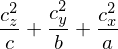

In [10]:
eqs['c_vect'][-1]